# Формирование модели монетизации для игры
Необходимо создать модель монетизации игрового приложения. Многие игры зарабатывают с помощью рекламы, поэтому нужно выбрать оптимальное время для ее запуска. Зная расходы на продвижение игры, можно рассчитать её окупаемость при разных сценариях. Предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:
- победа над первым врагом
- реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

## Материалы
- [Презентация](https://drive.google.com/file/d/19ceQjsxnQIeU0xiKTIEAti530Pk4bLu4/view?usp=sharing)
- [Дашборд](https://public.tableau.com/views/cosmo_bros/Dashboard_set_2?:language=en-US&:display_count=n&:origin=viz_share_link)

# Предобработка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 300


In [2]:
rc={'figure.figsize':(14, 10),
    'axes.titlesize': 24,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.autolayout': False,
    'axes.grid': False
    }
sns.set_theme(style = 'white', rc = rc)

In [3]:
game_actions = pd.read_csv('game_actions.csv') 
ad_costs = pd.read_csv('ad_costs.csv') 
user_source = pd.read_csv('user_source.csv')

In [4]:
for df in [game_actions, ad_costs, user_source]:
    display(df.info(), df.head(), df.describe(), df[df.duplicated(keep=False)])
    print('\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 21:49:07,building,spaceport,ff841992-d93b-462e-bc6e-18c24a514f36,satellite_orbital_assembly
freq,4,127957,59325,22,1866


,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


,source,day,cost





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


,user_id,source
count,13576,13576
unique,13576,4
top,1459624c-b46f-4849-a23b-47323ce55b7e,yandex_direct
freq,1,4817


,user_id,source


In [5]:
[display(game_actions[i].value_counts(dropna=False)) for i in ['event', 'building_type', 'project_type']]

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

spaceport          59325
assembly_shop      54494
research_center    14138
NaN                 7683
Name: building_type, dtype: int64

NaN                           133774
satellite_orbital_assembly      1866
Name: project_type, dtype: int64

[None, None, None]

Пропуски есть в таблице с данными о событиях. В столбце `event` 127957 значений `building` и 1866 значений `project`, именно столько ненулевых значений в `building_type` и в `project_type` соответственно, для остальных значений в этих двух столбцах стоят пропуски, которые нечем заменить


Также в `game_actions` есть дубликат, но возможно он обусловлен одновременной постройкой 2 сооружений, поэтому его не стоит убирать

Теперь в таблицах `game_actions` и `ad_costs` необходимо столбцы с датой привести к соответствующему виду

In [6]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

In [7]:
game_actions['user_id'].nunique()
game_actions['user_id'].str.strip().nunique()
user_source['user_id'].nunique()
user_source['user_id'].str.strip().nunique()

13576

13576

13576

13576

С `user_id` все в порядке

# EDA

## Цена за клик

Необходимо добавить столбцы с датами первого и последнего событий, а также столбец с неделей

In [8]:
game_actions['day'] = game_actions['event_datetime'].dt.date
game_actions['day'] = pd.to_datetime(game_actions['day'])
game_actions['first_day'] = game_actions.groupby('user_id')['day'].transform(lambda x: x.min())
game_actions['last_day'] = game_actions.groupby('user_id')['day'].transform(lambda x: x.max())
game_actions['week'] = game_actions.groupby('user_id')['day'].transform(lambda x: x.dt.to_period('W').dt.to_timestamp())

Также стоит добавить столбец с источником трафика, рассчитать количество построек для каждого игрока и количество дней активности

In [9]:
game_actions = game_actions.merge(user_source, on = 'user_id')
game_actions['building_count'] = game_actions.groupby('user_id')['building_type'].transform('count')
game_actions['day_count'] = game_actions.groupby('user_id')['day'].transform('nunique')
game_actions.head()

,event_datetime,event,building_type,user_id,project_type,day,first_day,last_day,week,source,building_count,day_count
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,2020-05-10,2020-05-04,youtube_channel_reklama,7,5
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,2020-05-10,2020-05-04,youtube_channel_reklama,7,5
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,2020-05-10,2020-05-04,youtube_channel_reklama,7,5
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,2020-05-10,2020-05-04,youtube_channel_reklama,7,5
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,2020-05-04,2020-05-10,2020-05-04,youtube_channel_reklama,7,5


Количество уникальных пользователей на каждый день для каждого источника

In [10]:
users_per_day = game_actions.groupby(['source', 'first_day'])['user_id'].nunique().reset_index()
users_per_day.head(7)
ad_costs.head(7)

,source,first_day,user_id
0,facebook_ads,2020-05-04,1184
1,facebook_ads,2020-05-05,694
2,facebook_ads,2020-05-06,345
3,facebook_ads,2020-05-07,224
4,facebook_ads,2020-05-08,139
5,facebook_ads,2020-05-09,84
6,facebook_ads,2020-05-10,56


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350


В таблице `ad_costs` находятся даты, в которые были совершены клики по объявлению, эти даты на один день меньше, чем те, в которые произошли первые события. Скорее всего в большинстве случаев пользователь в первый день кликал по объявлению и переходил в приложение, однако в некоторых записях клик и переход происходили в разные дни. Для удобства можно прибавить 1 день в таблице `ad_costs`

In [11]:
ad_costs['day'] = ad_costs['day'] + pd.Timedelta(days=1)
ad_costs = ad_costs.merge(users_per_day, left_on = ['source', 'day'], right_on = ['source', 'first_day'], how = 'left' )\
    .drop('first_day', axis = 1)

ad_costs['ratio'] = ad_costs['cost'] / ad_costs['user_id']

In [12]:
grouped_source = ad_costs.groupby('source').agg({'cost': 'sum', 'user_id': 'sum'}).reset_index()
grouped_source['ratio'] = grouped_source['cost'] / grouped_source['user_id']
grouped_source

,source,cost,user_id,ratio
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


Самая высокая средняя цена за клик - из `facebook`, затем идут `instagram`, `yandex` и `youtube`

In [13]:
ad_costs['cost'].sum() / ad_costs['user_id'].sum()

0.5600749106355349

Средняя стоимость привлечения пользователя

## Динамика изменений стоимости кликов и количества пользователей

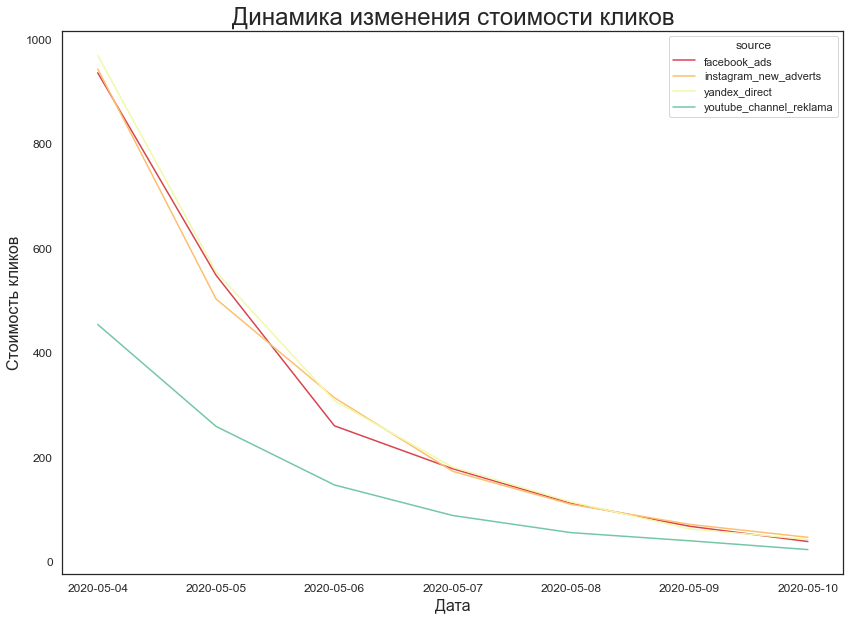

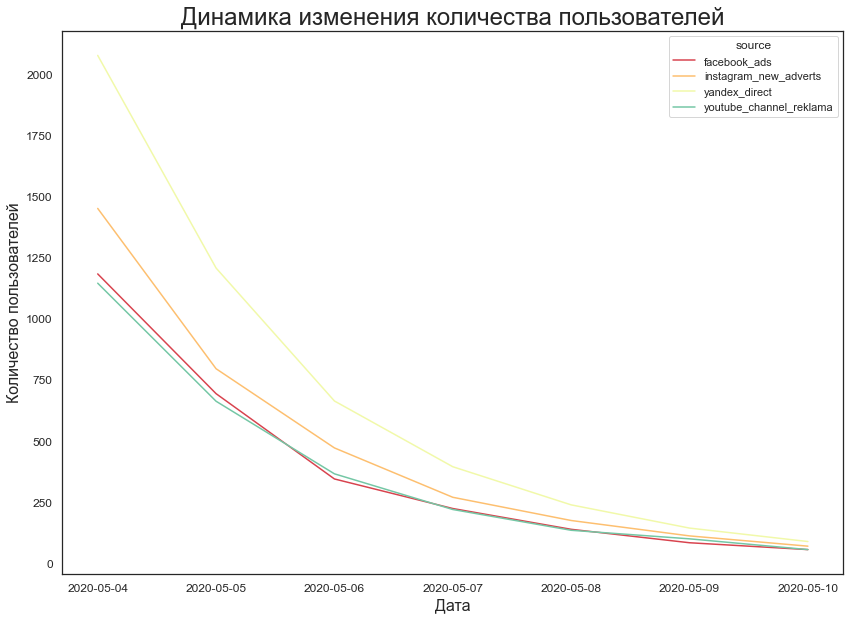

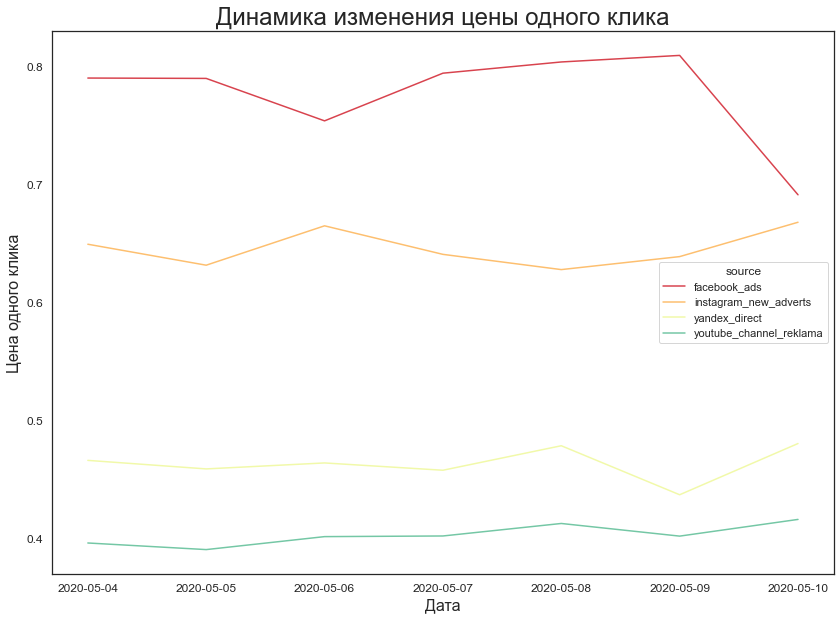

In [14]:
sns.lineplot(x = ad_costs['day'], y = ad_costs['cost'], hue = ad_costs['source'], palette = sns.color_palette('Spectral', 8)[::2])
plt.title('Динамика изменения стоимости кликов')
plt.ylabel('Стоимость кликов')
plt.xlabel('Дата')
plt.show();

sns.lineplot(x = ad_costs['day'], y = ad_costs['user_id'], hue = ad_costs['source'], palette = sns.color_palette('Spectral', 8)[::2])
plt.title('Динамика изменения количества пользователей')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.show();

sns.lineplot(x = ad_costs['day'], y = ad_costs['ratio'], hue = ad_costs['source'], palette = sns.color_palette('Spectral', 8)[::2])
plt.title('Динамика изменения цены одного клика')
plt.ylabel('Цена одного клика')
plt.xlabel('Дата')
plt.show();

- Со временем привлекали все меньше пользователей, соответственно снижалась и стоимость кликов
- Самые низкие показатели на всех графиках у youtube
- Из youtube и facebook привлекалось одинаковое количество людей, хотя цена за клик отличается почти в 2 раза
- Через yandex привлекается больше всего пользователей, притом цена за клик довольно низкая

## Профили пользователей

С учетом того что один показ рекламы в игре приносит прибыль 0.07, а средняя стоимость привлечения пользователя около 0.56, то при текущей модели монетизации игроку необходимо показать минимум 9 реклам для того, чтобы он окупился и принес прибыль

В качестве альтернативной модели монетизации можно:
- показывать рекламу всем игрокам раз в день в начале игровой сессии
- еще 2 рекламы для тех, кто завершил 1 уровень

Т. к. дней активности точно не больше, чем количество построек, а игрков, завершивших уровень, только половина, то такой подход снизит рекламную нагрузку

In [15]:
def models(df):
    profit = df.groupby(['user_id', game_actions['event_datetime'].dt.to_period('W').dt.to_timestamp()])\
            .agg({'building_type':'count', 'day': 'nunique', 'event': 'last'}).reset_index()
    profit.loc[profit['event'] == 'finished_stage_1', ['day']] += 2
    profit = profit.assign(profit_1 = lambda x: x['building_type'] * 0.07,
                           profit_2 = lambda x: x['day'] * 0.07)
    profit = profit.drop(['user_id', 'event_datetime', 'event'], axis=1).sum().to_frame()
    profit.index = ['ads_cnt_model_1', 'ads_cnt_model_2', 'profit_model_1', 'profit_model_2']
    return profit
models(game_actions)

,0
ads_cnt_model_1,127957.00
ads_cnt_model_2,106835.00
profit_model_1,8956.99
profit_model_2,7478.45


Теперь стоит составить несколько профилей пользователей в зависимости от их тактики игры:
- те, кто завершили проект (`project`)
- те, кто победили другого игрока (`victory`)
- все остальные (`not_finished`)
- вообще все игроки (`game_actions`)

In [17]:
project = game_actions.query('event == "project"')
finished_stage_1 = game_actions.query('event == "finished_stage_1"')
print('Закончили проект:', project['user_id'].nunique())
print('Закончили 1 уровень:', finished_stage_1['user_id'].nunique())
print('Всего пользователей:', game_actions['user_id'].nunique())
len(set(project['user_id']) & set(finished_stage_1['user_id']))

Закончили проект: 1866
Закончили 1 уровень: 5817
Всего пользователей: 13576


1866

Все 1866 человек, которые реализовали проект, входят в 5817, которые закончили 1 уровень любым способом. Соответственно 3951 игрок закончили уровень, победив другого игрока, а 7759 не закончили 1 уровень вообще

In [18]:
victory = finished_stage_1[~finished_stage_1['user_id'].isin(project['user_id'].unique())]
not_finished = game_actions[~game_actions['user_id'].isin(finished_stage_1['user_id'].unique())]

project = game_actions[game_actions['user_id'].isin(project['user_id'].unique())]
victory = game_actions[game_actions['user_id'].isin(victory['user_id'].unique())]

project['user_id'].nunique()
victory['user_id'].nunique()
not_finished['user_id'].nunique()

1866

3951

7759

## Метрики LTV, CAC, ROI

In [19]:
game_actions['event_datetime'].max() - game_actions['event_datetime'].min()

Timedelta('32 days 12:32:48')

Есть данные примерно за месяц активностей игроков, для lifetime стоит взять неделю. Получится 5 недель, но 5-я не полная (4 дня). Также для `project` и `victory` lifetime будет до момента завершения 1 уровня, т. к. данных о последующих действиях игроков нет, а для `not_finished` lifetime до ухода

In [20]:
def cohorts(df, cost, source = ['youtube_channel_reklama', 'facebook_ads', 'instagram_new_adverts', 'yandex_direct']):
    def cohort_period(cohort):
        cohort['week_number'] = np.arange(len(cohort)) + 1
        return cohort
    
    data = eval(df).query('source in @source')
    cost = cost.query('source in @source').reset_index().drop('index', axis=1)  
    cohort = data.groupby(['first_day', 'week']).agg({'user_id': pd.Series.nunique})\
             .groupby(level=0).apply(cohort_period).reset_index(inplace=False)\
             .set_index(['week_number', 'first_day'], inplace=False)
    cohort_size = cohort['user_id'].groupby(level=1).first().sum()
    cohort = cohort['user_id'].unstack(1).T.sum(axis = 0).to_frame().T
    cohort = pd.concat([cohort, cohort.divide(cohort_size, axis=0) * 100])
    cohort.index = ['cohort size', 'retention rate, (%)']
    
    if df == 'project' and (source in ['facebook_ads', 'instagram_new_adverts']):
        temp = data.groupby('user_id')['week'].last().value_counts().to_frame()\
       .reset_index().append(pd.DataFrame([{'index': pd.to_datetime('2020-05-04'), 'week': 0}]))\
       .sort_values('index').assign(index = np.arange(1, 6)).set_index('index').T
    else:
        temp = data.groupby('user_id')['week'].last().value_counts().to_frame()\
                   .reset_index().sort_values('index').assign(index = np.arange(1, 6)).set_index('index').T
    temp.index = ['complete 1 level or left, cumulative (%)']
    cohort = pd.concat([cohort, temp])
    cohort.iloc[2, :] = np.cumsum(cohort[cohort.index == cohort.index[2]].values / cohort.iloc[0, 0]) * 100
        
    cost['user_id'] = data.groupby('user_id')[['source']].first()\
    .reset_index().groupby('source')['user_id'].count().reset_index()['user_id']
    cost['cost'] = cost['user_id'] * cost['ratio']   
    cac = cost['cost'].sum() / cost['user_id'].sum()
    cac = pd.Series([cac]*5).to_frame().T
    cac.index = ['CAC']
    cac.columns = np.arange(1, 6)
    cohort = pd.concat([cohort, cac])
    
    profit = data.groupby(['user_id', game_actions['event_datetime'].dt.to_period('W').dt.to_timestamp()])\
            .agg({'building_type':'count', 'day': 'nunique', 'event': 'last'}).reset_index()
    profit.loc[profit['event'] == 'finished_stage_1', ['day']] += 2
    profit = profit.assign(profit_1 = lambda x: x['building_type'] * 0.07,
                           profit_2 = lambda x: x['day'] * 0.07).groupby('event_datetime')\
                           [['profit_1', 'profit_2']].sum().cumsum().T
    profit.index = ['LTV model 1, cumulative', 'LTV model 2, cumulative']
    profit.columns = np.arange(1, 6)
    cohort = pd.concat([cohort, profit])
    cohort.iloc[4, :] = ((cohort[cohort.index == cohort.index[4]].values / cohort[1][0]) * np.array(cohort.columns))
    cohort.iloc[5, :] = ((cohort[cohort.index == cohort.index[5]].values / cohort[1][0]) * np.array(cohort.columns))
    
    lc1 = pd.Series((((cohort[cohort.index == cohort.index[4]].values / cohort[cohort.index == cohort.index[3]]\
                         .values))).tolist()[0]).to_frame().T
    lc1.index = ['LTV/CAC ratio model 1']
    lc1.columns = np.arange(1, 6)
    cohort = pd.concat([cohort, lc1])
    lc2 = pd.Series((((cohort[cohort.index == cohort.index[5]].values / cohort[cohort.index == cohort.index[3]]\
                       .values))).tolist()[0]).to_frame().T
    lc2.index = ['LTV/CAC ratio model 2']
    lc2.columns = np.arange(1, 6)
    cohort = pd.concat([cohort, lc2])
    
    roi = profit
    roi.index = ['ROI model 1, (%)', 'ROI model 2, (%)']
    cohort = pd.concat([cohort, roi])
    cohort.iloc[8, :] = ((cohort[cohort.index == cohort.index[8]].values - cost['cost'].sum()) / cost['cost'].sum()) * 100
    cohort.iloc[9, :] = ((cohort[cohort.index == cohort.index[9]].values - cost['cost'].sum()) / cost['cost'].sum()) * 100
    return cohort

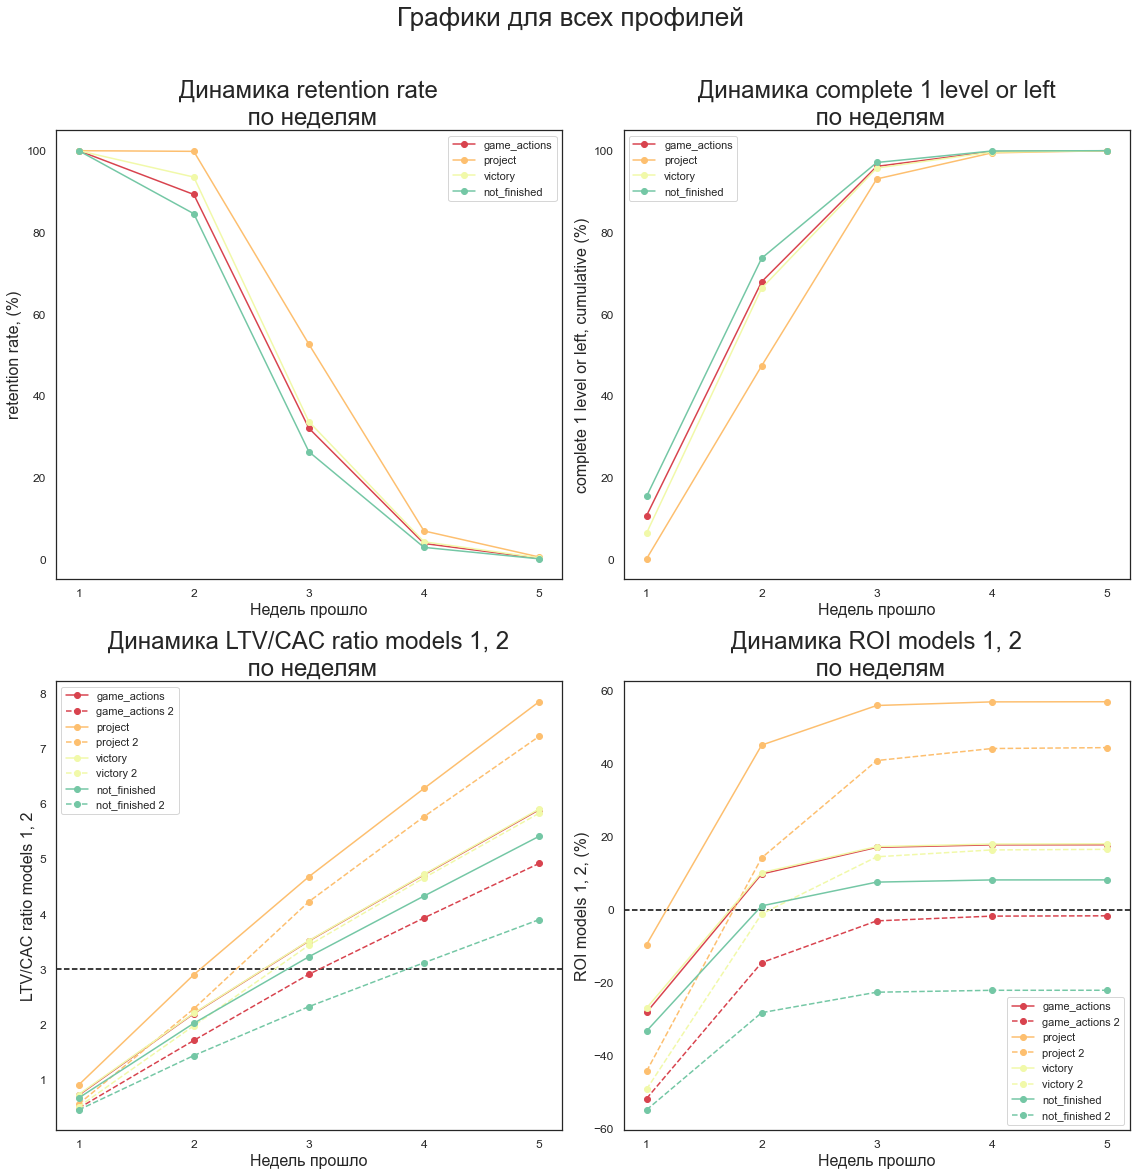

In [21]:
plt.figure(figsize=(16, 16))
plt.suptitle('Графики для всех профилей', fontsize = 26, y = 1.02)
for num, name in enumerate(cohorts('game_actions', grouped_source).iloc[[1, 2, 6, 8], :].index):
   
    ax = plt.subplot(2, 2, num + 1)
    if num in [0,1]:
        ax.set_title(f'Динамика {name.split(",")[0]}\n по неделям')
        ax.set_ylabel(f'{name}')
    else:
        ax.set_title(f'Динамика {name.split(",")[0].replace("l 1", "ls 1, 2")}\n по неделям')
        ax.set_ylabel(f'{name.replace("l 1", "ls 1, 2")}')
    ax.set_xlabel('Недель прошло')
    ax.set_xticks(np.arange(1, 6))
    if num == 2:
        ax.axhline(y = 3, color = 'black', ls = '--')
    if num == 3:
        ax.axhline(y = 0, color = 'black', ls = '--')
    plt.tight_layout()
    for n, profile in enumerate(['game_actions', 'project', 'victory', 'not_finished']):
        if num in [0, 1]:
            ax.plot(cohorts(profile, grouped_source).T.index, 
                    cohorts(profile, grouped_source).T[name], 'o-', label = profile, 
                    c = sns.color_palette('Spectral', 8)[n*2])
            ax.legend()
        else:
            ax.plot(cohorts(profile, grouped_source).T.index, 
                    cohorts(profile, grouped_source).T[name], 'o-', 
                    label = profile, c = sns.color_palette('Spectral', 8)[n*2])
            ax.plot(cohorts(profile, grouped_source).T.index, 
                    cohorts(profile, grouped_source).T[name.replace('1', '2')], 'o--', 
                    label = profile+' 2', c = sns.color_palette('Spectral', 8)[n*2])
            ax.legend()
plt.show();

- Показатели удержания самые высокие у `project`, затем `victory`, `game_actions` и `not_finished`
- Показатели завершения уровня или ухода из игры имеют обратный порядок, т. к. связаны с удержанием - чем больше осталось, тем меньше закончили / ушли и наоборот
- Наибольший 'скачок' в значениях у этих 2 графиков произошел во 2 и 3 недели, т. е. именно к концу 3 недели большинство игроков закончили уровень, либо покинули игру
- Для отношения LTV/CAC оптимальным считается значение 3, все профили обеих моделей превосходят это значение к концу месяца. Причем наибольшие соотношения у `project`, у обеих моделей `victory` одинаковое соотношение, т.е модель не влияет на LTV, а у `not_finished`, наоборот, самый большой разброс
- Для ROI только профили `game_actions` и `not_finished` 2 модели не превысили 0, остальные со 2 - 3 недели начали окупаться

Таким образом рекламная нагрузка снижена, однако при новой модели монетизации нет окупаемости (по всем пользователям `game_actions`), значит можно попробовать снизить расходы на маркетинг



Теперь можно рассмотреть динамику `retention rate`, `complete 1 level or left`, `LTV/CAC ratio model 1, 2`, `ROI model 1, 2` каждого профиля по неделям в разрезе по источникам трафика и каждого источника трафика по неделям в разрезе по профилям

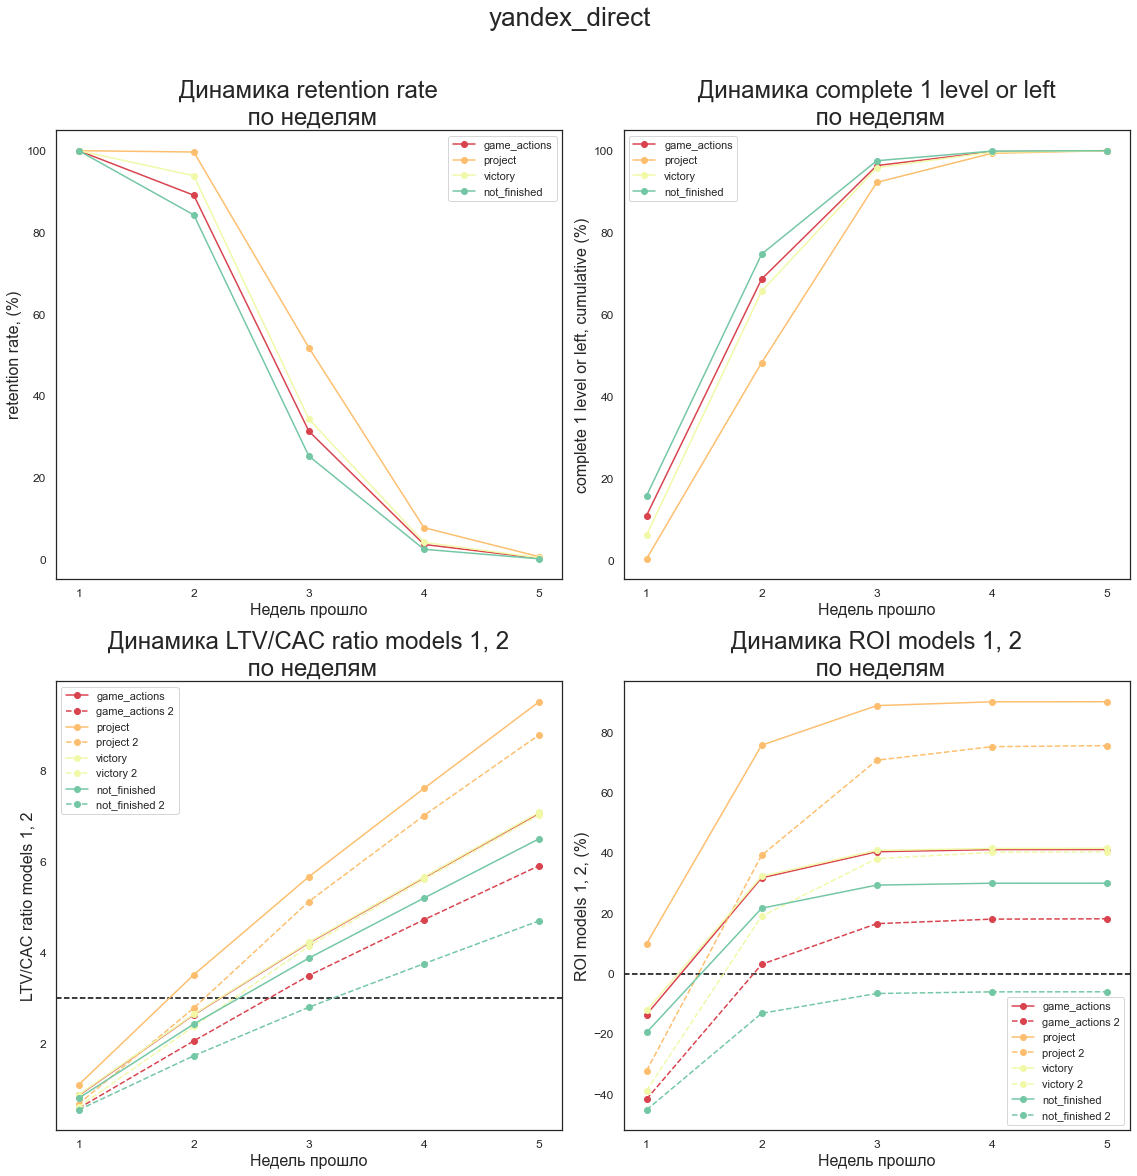

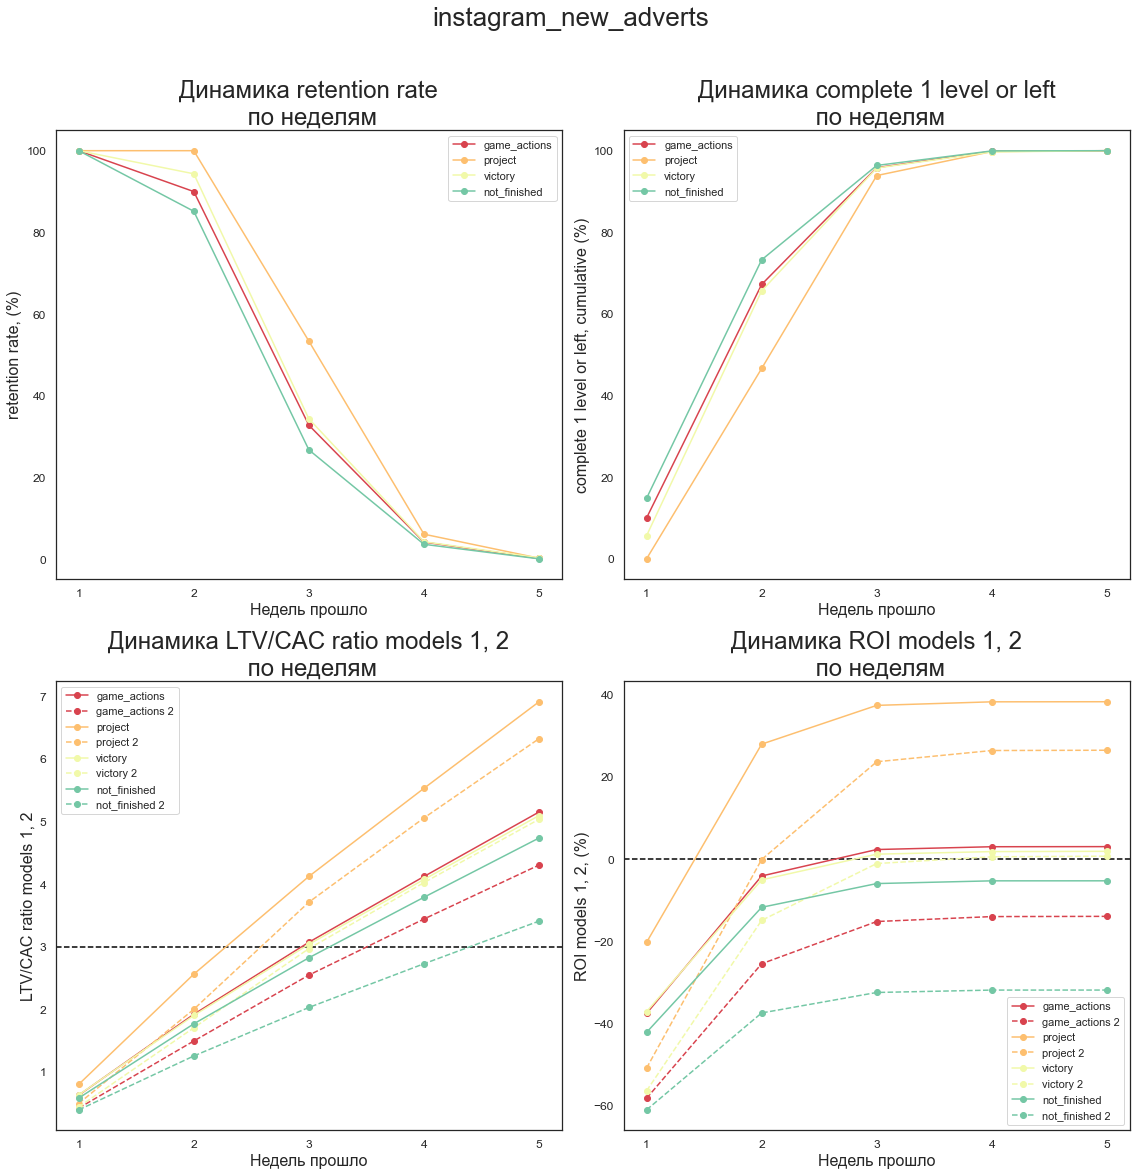

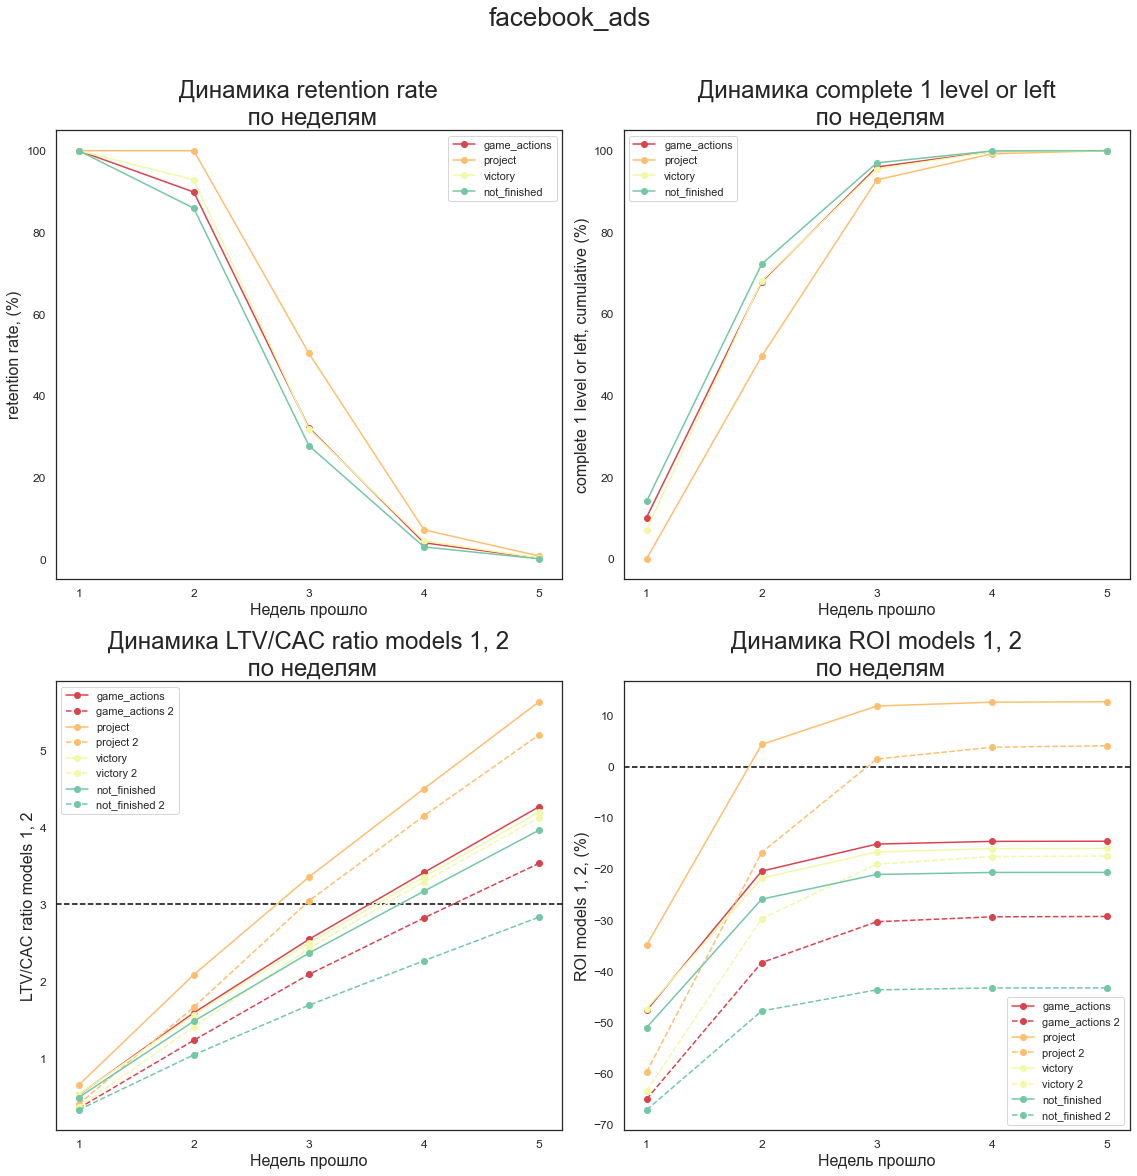

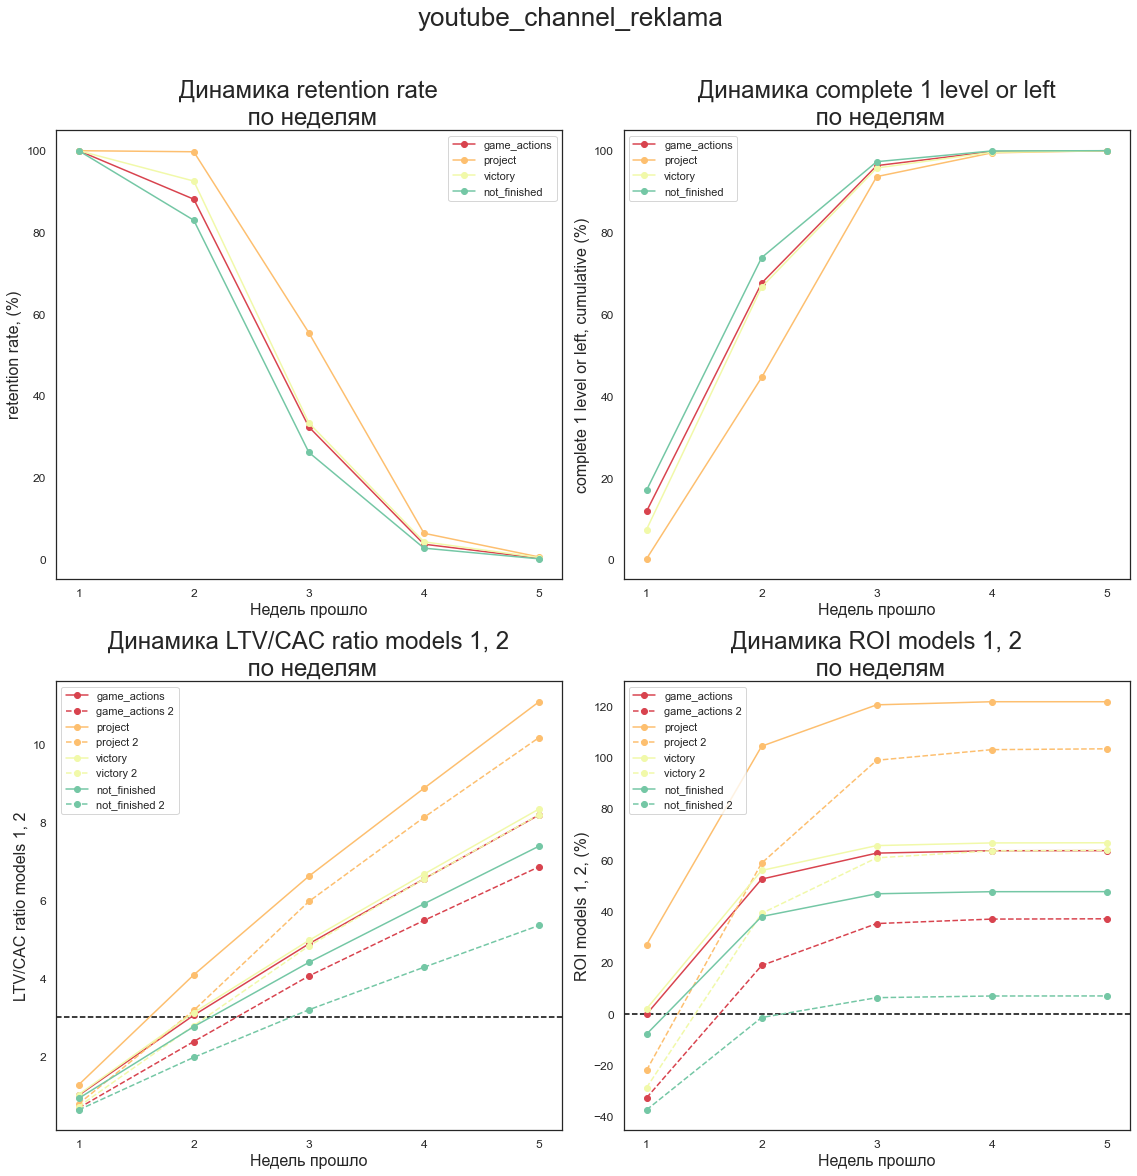

In [22]:
for source in ['yandex_direct', 'instagram_new_adverts', 'facebook_ads', 'youtube_channel_reklama']:
    plt.figure(figsize=(16, 16))
    plt.suptitle(source, fontsize = 26, y = 1.02)
    for num, name in enumerate(cohorts('game_actions', grouped_source).iloc[[1, 2, 6, 8], :].index):
        ax = plt.subplot(2, 2, num + 1)
        if num in [0,1]:
            ax.set_title(f'Динамика {name.split(",")[0]}\n по неделям')
            ax.set_ylabel(f'{name}')
        else:
            ax.set_title(f'Динамика {name.split(",")[0].replace("l 1", "ls 1, 2")}\n по неделям')
            ax.set_ylabel(f'{name.replace("l 1", "ls 1, 2")}')
        ax.set_xlabel('Недель прошло')
        ax.set_xticks(np.arange(1, 6))
        if num == 2:
            ax.axhline(y = 3, color = 'black', ls = '--')
        if num == 3:
            ax.axhline(y = 0, color = 'black', ls = '--')
        plt.tight_layout()
        for n, profile in enumerate(['game_actions', 'project', 'victory', 'not_finished']):
            if num in [0, 1]:
                ax.plot(cohorts(profile, grouped_source, source).T.index, 
                        cohorts(profile, grouped_source, source).T[name], 'o-', label = profile, 
                        c = sns.color_palette('Spectral', 8)[n*2])
                ax.legend()
            else:
                ax.plot(cohorts(profile, grouped_source, source).T.index, 
                        cohorts(profile, grouped_source, source).T[name], 'o-', 
                        label = profile, c = sns.color_palette('Spectral', 8)[n*2])
                ax.plot(cohorts(profile, grouped_source, source).T.index, 
                        cohorts(profile, grouped_source, source).T[name.replace('1', '2')], 'o--', 
                        label = profile+' 2', c = sns.color_palette('Spectral', 8)[n*2])
                ax.legend()
plt.show();

- `yandex`:
    - LTV/CAC больше 3 к концу месяца для всех профилей, самый не прибыльный - `not_finished` по 2 модели, также только этот профиль оказался убыточен по ROI
- `instagram`:
    - По LTV/CAC похожий график, только профили пересекли соотношение 3 к 4 неделе
    - По ROI окупились только `project` обе модели; `victory` обе модели и `game_actions` 2 модель около 0, остальные убыточны
- `facebook`:
    - Соотношение LTV/CAC для `not_finished` по 2 модели оказалось меньше 3, а по ROI окупились толкьо 2 модели `project`
- `youtube`:
    - Все профили пересекли 3 к 3 неделе, соотношение LTV/CAC достигает наивысшего значения для этого источника трафика
    - По ROI также окупилиcь все профили 


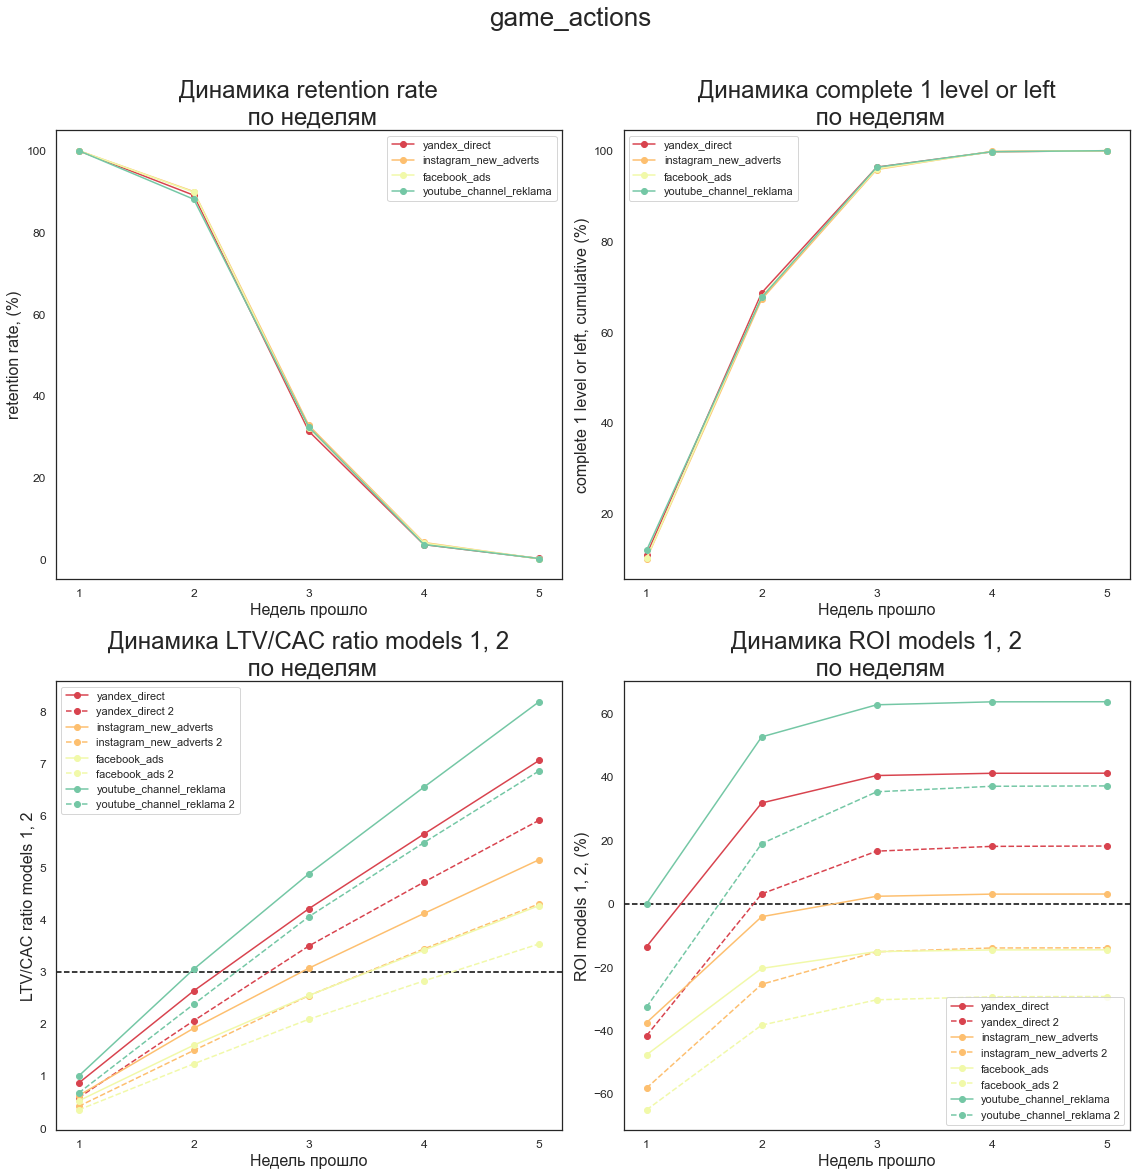

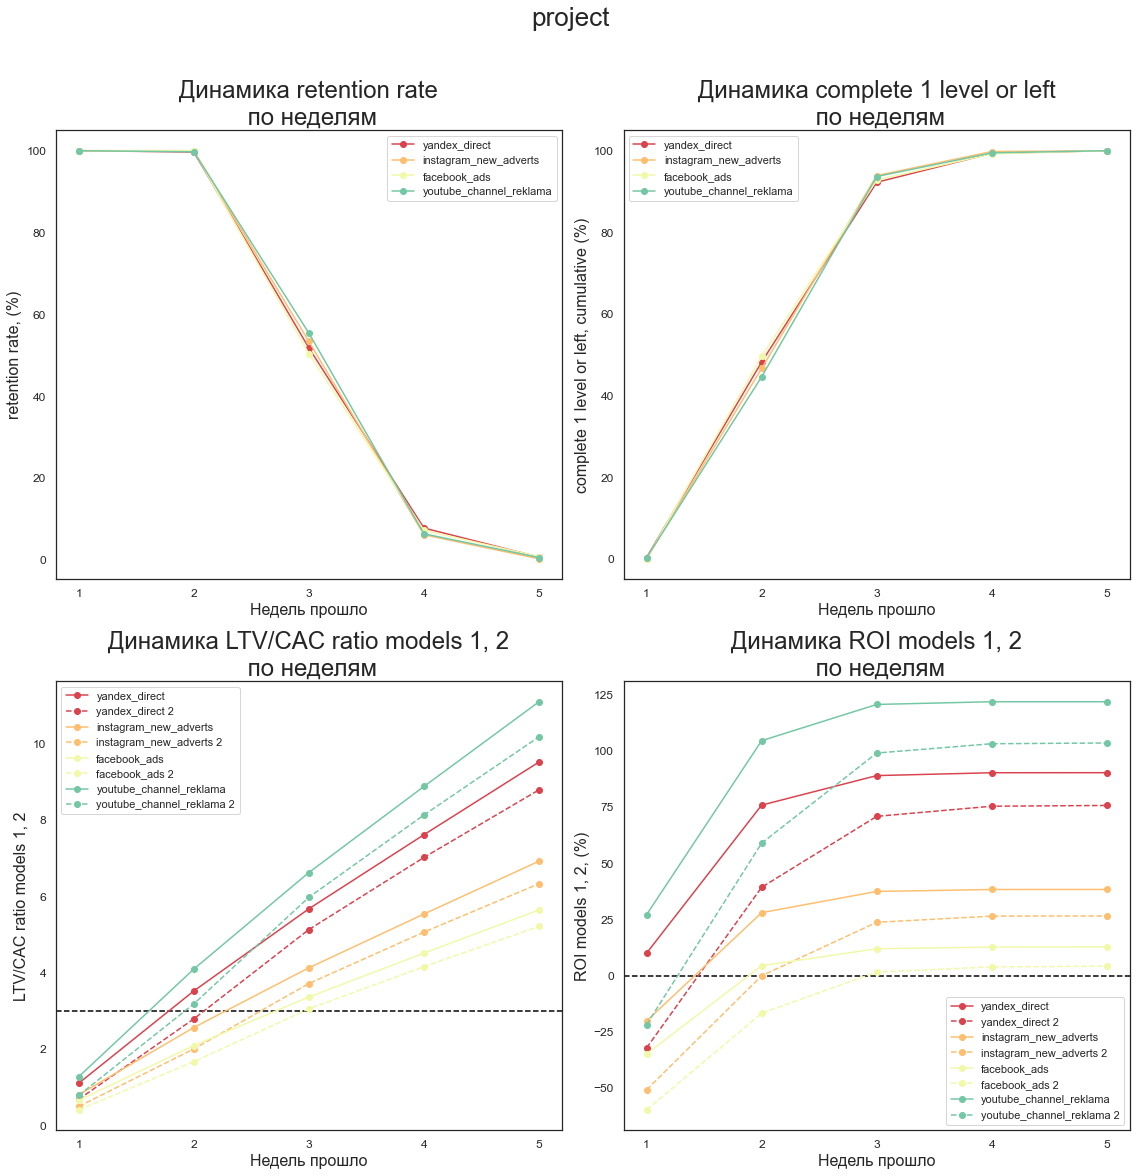

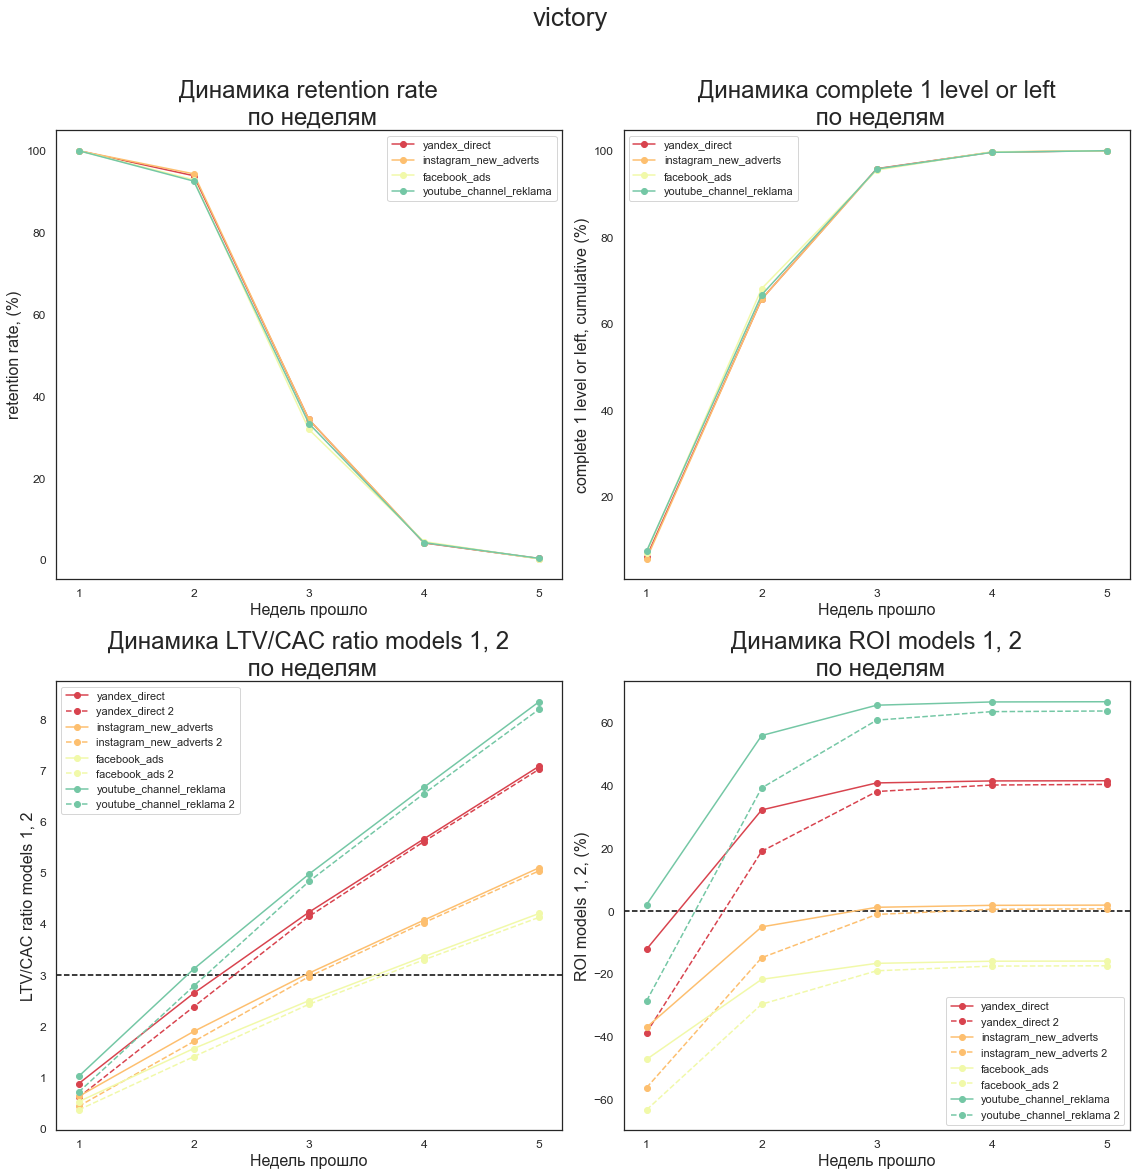

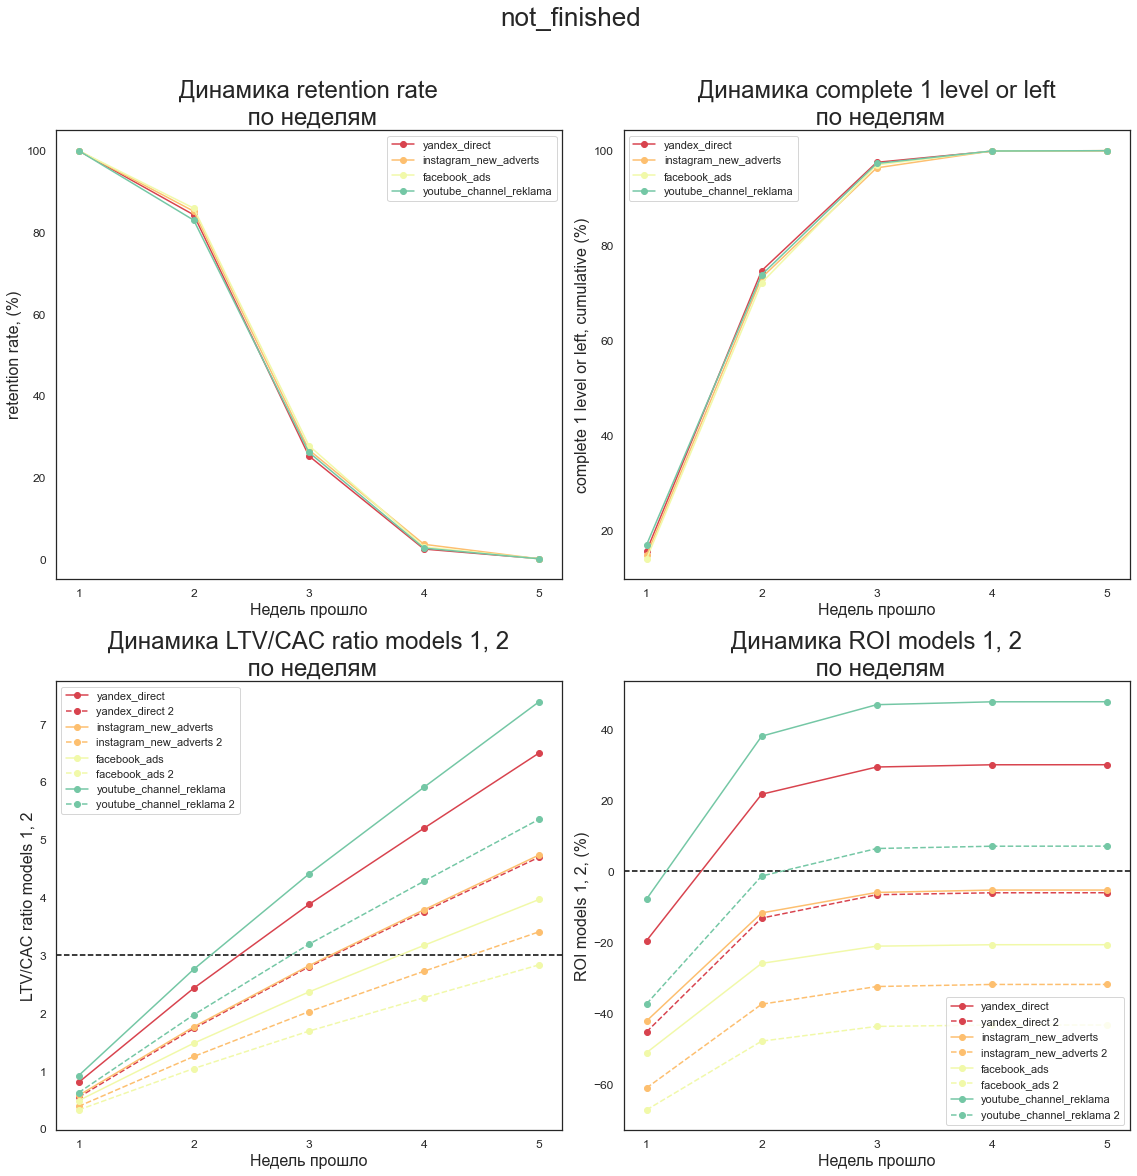

In [23]:
for profile in ['game_actions', 'project', 'victory', 'not_finished']:
    plt.figure(figsize=(16, 16))
    plt.suptitle(profile, fontsize = 26, y = 1.02)
    for num, name in enumerate(cohorts('game_actions', grouped_source).iloc[[1, 2, 6, 8], :].index):
        ax = plt.subplot(2, 2, num + 1)
        if num in [0,1]:
            ax.set_title(f'Динамика {name.split(",")[0]}\n по неделям')
            ax.set_ylabel(f'{name}')
        else:
            ax.set_title(f'Динамика {name.split(",")[0].replace("l 1", "ls 1, 2")}\n по неделям')
            ax.set_ylabel(f'{name.replace("l 1", "ls 1, 2")}')
        ax.set_xlabel('Недель прошло')
        ax.set_xticks(np.arange(1, 6))
        if num == 2:
            ax.axhline(y = 3, color = 'black', ls = '--')
        if num == 3:
            ax.axhline(y = 0, color = 'black', ls = '--')
        plt.tight_layout()
        for n, source in enumerate(['yandex_direct', 'instagram_new_adverts', 'facebook_ads', 'youtube_channel_reklama']):
            if num in [0, 1]:
                ax.plot(cohorts(profile, grouped_source, source).T.index, 
                        cohorts(profile, grouped_source, source).T[name], 'o-', label = source, 
                        c = sns.color_palette('Spectral', 8)[n*2])
                ax.legend()
            else:
                ax.plot(cohorts(profile, grouped_source, source).T.index, 
                        cohorts(profile, grouped_source, source).T[name], 'o-', 
                        label = source, c = sns.color_palette('Spectral', 8)[n*2])
                ax.plot(cohorts(profile, grouped_source, source).T.index, 
                        cohorts(profile, grouped_source, source).T[name.replace('1', '2')], 'o--', 
                        label = source+' 2', c = sns.color_palette('Spectral', 8)[n*2])
                ax.legend()
plt.show();

- Источники трафика вообще не влияют на удержание
- Порядок источников по убыванию значений и LTV/CAC, и ROI такой: `youtube`, `yandex`, `instagram`, `facebook`
- Можно отметить, что `instagram` и `facebook` имеют хужшие показатели для LTV/CAC для всех профилей, а по ROI окупаются только для `project`, по остальным профилям эти источники убыточны

С учетом самой высокой средней цены клика в `facebook` и `instagram`, малого числа привлеченных пользователей и низкой окупаемости игроков можно исключить эти источники трафика и посмотреть на изменения ROI во 2 модели. Также можно поочередно убирать каждый источник и сравнивать показатели

In [24]:
print('all sources')
cohorts('game_actions', grouped_source).T['ROI model 2, (%)'].to_frame().T
for i in game_actions['source'].unique().tolist():
    sources = game_actions['source'].unique().tolist()
    sources.remove(i)
    print(f'{i} excluded')
    cohorts('game_actions', grouped_source, sources).T['ROI model 2, (%)'].to_frame().T

all sources


,1,2,3,4,5
"ROI model 2, (%)",-51.667485,-14.45421,-3.030245,-1.731251,-1.645633


youtube_channel_reklama excluded


,1,2,3,4,5
"ROI model 2, (%)",-54.77899,-19.913185,-9.293424,-8.065966,-7.985635


facebook_ads excluded


,1,2,3,4,5
"ROI model 2, (%)",-46.419814,-5.101575,7.667816,9.097885,9.187585


instagram_new_adverts excluded


,1,2,3,4,5
"ROI model 2, (%)",-49.083405,-10.089152,1.794603,3.132313,3.230069


yandex_direct excluded


,1,2,3,4,5
"ROI model 2, (%)",-55.837348,-21.747566,-11.179395,-9.965906,-9.890307


Видно, что при исключении `youtube` или `yandex` ROI снижается, а при убирании `facebook` и `instagram` растет. Есть смысл средства, потраченные на эти источники трафика, вложить в рекламу для `youtube` и `yandex`

## Снижение маркетинговых затрат

In [25]:
game_actions.groupby(['source', 'user_id']).agg({'day': 'nunique', 'building_count': 'first'})\
            .reset_index().groupby('source').mean()
grouped_source

,day,building_count
source,,
facebook_ads,7.089875,9.585840
instagram_new_adverts,7.065133,9.505527
yandex_direct,6.979033,9.348557
youtube_channel_reklama,6.928146,9.299702


,source,cost,user_id,ratio
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


Средние значения количества дней и количества построек не зависят от источника трафика, поэтому можно заменить в исходных данных `facebook` на `youtube`, а `instagram` на `yandex` (с учетом пропорций количества пользователей)

In [26]:
def src_change(src):
    if src in ['facebook_ads', 'youtube_channel_reklama']:
        return 'youtube_channel_reklama'
    if src in ['instagram_new_adverts', 'yandex_direct']:
        return 'yandex_direct'

        
game_actions['source'] = game_actions['source'].apply(src_change)
project['source'] = project['source'].apply(src_change)
victory['source'] = victory['source'].apply(src_change)
not_finished['source'] = not_finished['source'].apply(src_change)
for df in [game_actions, project, victory, not_finished]:
    df.groupby('user_id')[['source']].first().reset_index()['source'].value_counts()

yandex_direct              8164
youtube_channel_reklama    5412
Name: source, dtype: int64

yandex_direct              1096
youtube_channel_reklama     770
Name: source, dtype: int64

yandex_direct              2412
youtube_channel_reklama    1539
Name: source, dtype: int64

yandex_direct              4656
youtube_channel_reklama    3103
Name: source, dtype: int64

Теперь распределение пользователей для 2 источников такое. Можно перезаписать данные в `grouped_source`

In [27]:
grouped_source
grouped_source = pd.DataFrame({'source': ['yandex_direct', 'youtube_channel_reklama'], 'cost': [8164 * 0.463590, 5412 * 0.397662],
              'user_id': [8164, 5412], 'ratio': [0.463590, 0.397662]})
grouped_source

,source,cost,user_id,ratio
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


,source,cost,user_id,ratio
0,yandex_direct,3784.748760,8164,0.463590
1,youtube_channel_reklama,2152.146744,5412,0.397662


In [28]:
grouped_source['cost'].sum()
grouped_source['user_id'].sum()
grouped_source['cost'].sum() / grouped_source['user_id'].sum()

5936.895504

13576

0.4373081543901002

При том же числе пользователей и 2 источниках затраты на маркетинг и средняя цена за клик уменьшились

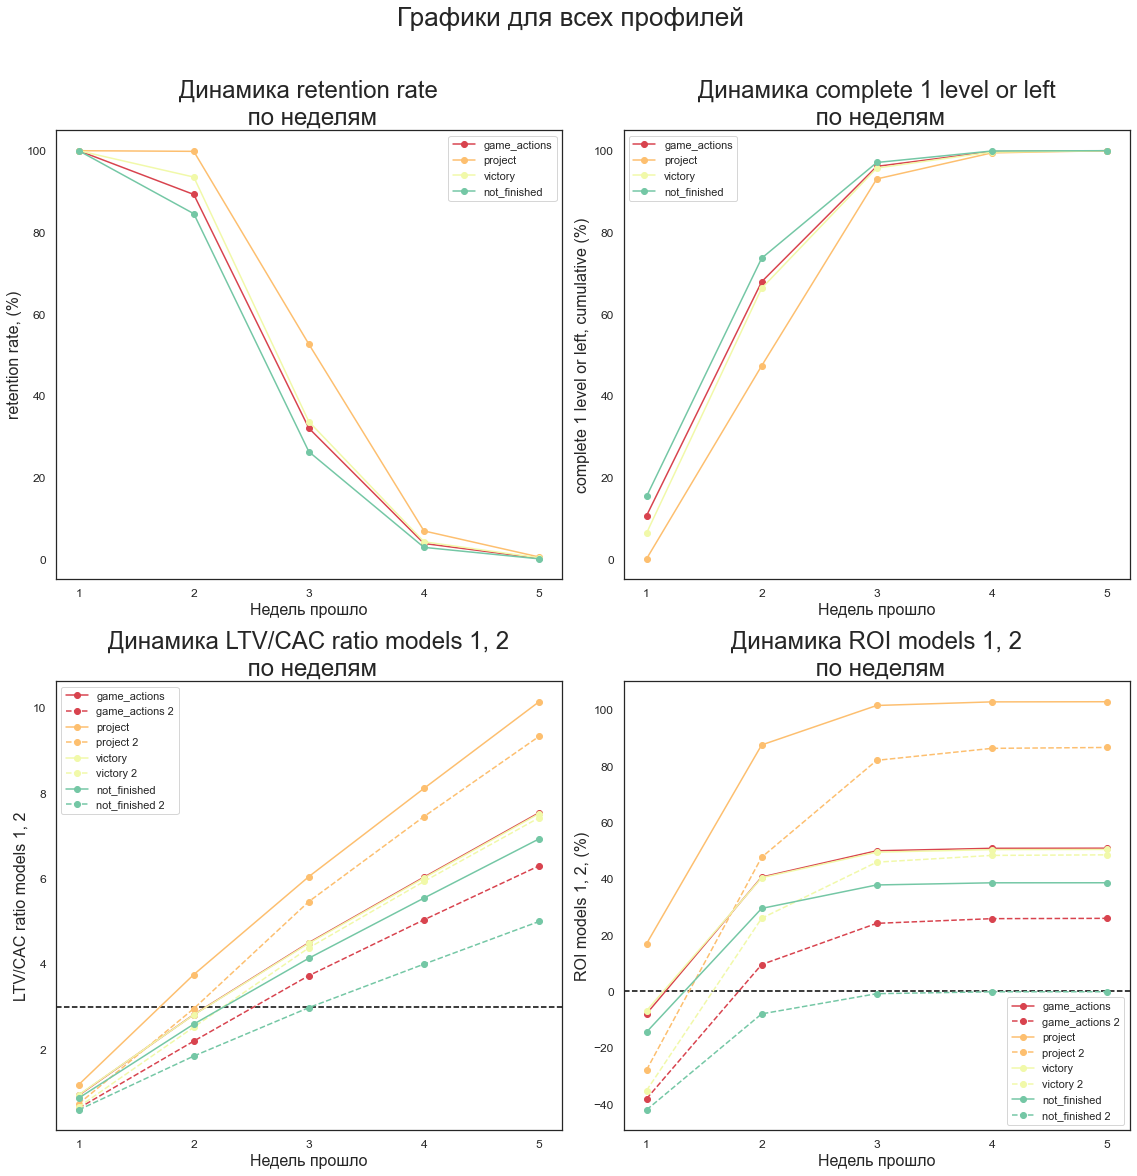

In [29]:
plt.figure(figsize=(16, 16))
plt.suptitle('Графики для всех профилей', fontsize = 26, y = 1.02)
for num, name in enumerate(cohorts('game_actions', grouped_source).iloc[[1, 2, 6, 8], :].index):
   
    ax = plt.subplot(2, 2, num + 1)
    if num in [0,1]:
        ax.set_title(f'Динамика {name.split(",")[0]}\n по неделям')
        ax.set_ylabel(f'{name}')
    else:
        ax.set_title(f'Динамика {name.split(",")[0].replace("l 1", "ls 1, 2")}\n по неделям')
        ax.set_ylabel(f'{name.replace("l 1", "ls 1, 2")}')
    ax.set_xlabel('Недель прошло')
    ax.set_xticks(np.arange(1, 6))
    if num == 2:
        ax.axhline(y = 3, color = 'black', ls = '--')
    if num == 3:
        ax.axhline(y = 0, color = 'black', ls = '--')
    plt.tight_layout()
    for n, profile in enumerate(['game_actions', 'project', 'victory', 'not_finished']):
        if num in [0, 1]:
            ax.plot(cohorts(profile, grouped_source).T.index, 
                    cohorts(profile, grouped_source).T[name], 'o-', label = profile, 
                    c = sns.color_palette('Spectral', 8)[n*2])
            ax.legend()
        else:
            ax.plot(cohorts(profile, grouped_source).T.index, 
                    cohorts(profile, grouped_source).T[name], 'o-', 
                    label = profile, c = sns.color_palette('Spectral', 8)[n*2])
            ax.plot(cohorts(profile, grouped_source).T.index, 
                    cohorts(profile, grouped_source).T[name.replace('1', '2')], 'o--', 
                    label = profile+' 2', c = sns.color_palette('Spectral', 8)[n*2])
            ax.legend()
plt.show();

По сравнению с предыдущими графиками до снижения маркетинговых затрат на этих видно, что:
- соотношение LTV/CAC превысило 3 на неделю раньше
- новая модель монетизации наконец стала окупаться по ROI
- также новая модель окупается лучше, чем изначальная (25% против 17%)

Теперь новая модель монетизации также включает в себя и оптимизацию маркетинговых затрат (замену `facebook` и `instagram` на `youtube` и `yandex`) 

# Проверка гипотез

## Гипотеза о различии времени прохождения уровня между пользователями, которые заканчивают уровень разными способами

Так как 0-я гипотеза - это гипотеза об отсутствии различий, а альтернативная - это гипотеза о значимости различий, то их можно сформулировать так:

- H0: время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, не отличается;
- H1: время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, отличается

In [30]:
alpha = 0.05 # критический уровень статистической значимости для всех тестов

Теперь необходимо найти разницу между самой последней и самой ранней записями в `event_datetime` для каждого пользователя, а затем привести полученное значение к часам

In [31]:
def profile_sample(df):
    return df.groupby('user_id').agg({'event_datetime': ['min', 'max']}) \
           .assign(event_duration_hours = lambda x: (x['event_datetime']['max'] - x['event_datetime']['min'])\
                   / np.timedelta64(1, 'h')).reset_index()[['user_id', 'event_duration_hours']]


project_sample = profile_sample(project)['event_duration_hours'].to_frame()
project_sample.shape
project_sample['event_duration_hours'].mean()
project_sample.head()
victory_sample = profile_sample(victory)['event_duration_hours'].to_frame()
victory_sample.shape
victory_sample['event_duration_hours'].mean()
victory_sample.head()

(1866, 1)

323.01364862450947

,event_duration_hours
0,282.648333
1,381.124444
2,481.210556
3,337.755556
4,353.751944


(3951, 1)

266.5066878286794

,event_duration_hours
0,154.645000
1,301.279167
2,306.834722
3,271.442222
4,145.981111


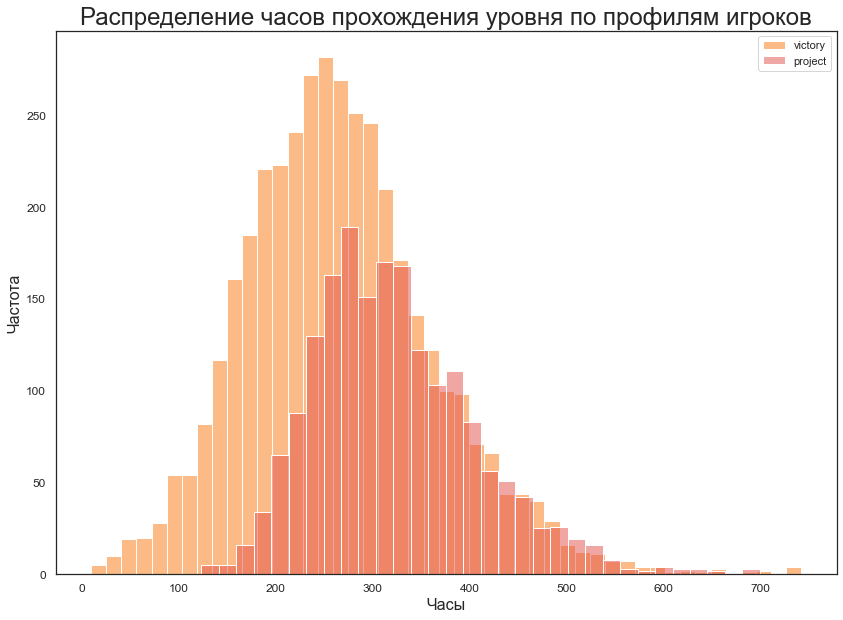

In [32]:
sns.histplot(victory_sample['event_duration_hours'], label = 'victory',
             color = sns.color_palette('Spectral')[1])
sns.histplot(project_sample['event_duration_hours'], label = 'project', alpha = 0.5,
             color = sns.color_palette('Spectral')[0])

plt.xlabel('Часы')
plt.ylabel('Частота')
plt.title('Распределение часов прохождения уровня по профилям игроков')
plt.legend()
plt.show();

Так как размеры выборок не равны, можно применить метод оверсэмплинга

In [33]:
project_sample = pd.concat([project_sample, project_sample\
                            .sample((len(victory_sample) - len(project_sample)), replace = True)])
print(len(project_sample))
print(len(victory_sample))


3951
3951


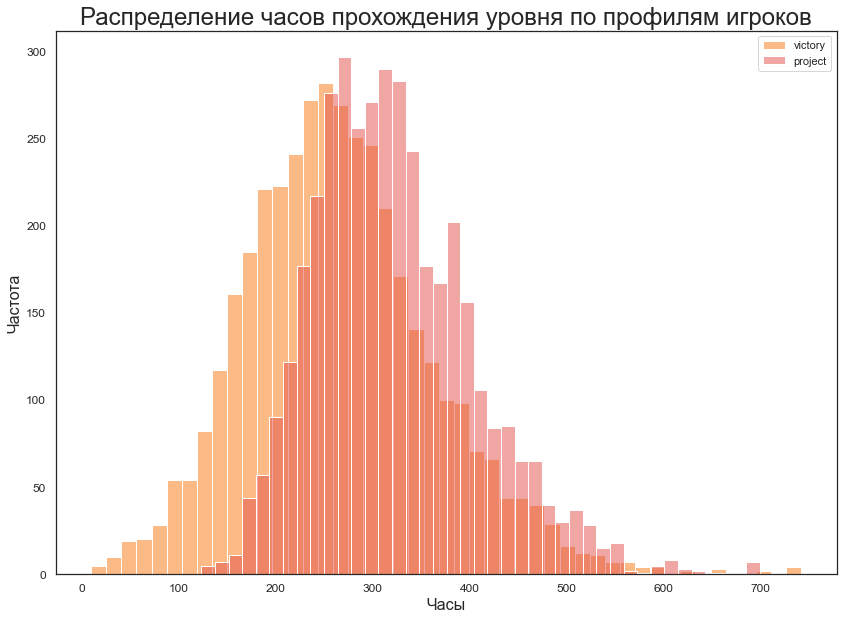

In [34]:
sns.histplot(victory_sample['event_duration_hours'], label = 'victory',
             color = sns.color_palette('Spectral')[1])
sns.histplot(project_sample['event_duration_hours'], label = 'project', alpha = 0.5,
             color = sns.color_palette('Spectral')[0])

plt.xlabel('Часы')
plt.ylabel('Частота')
plt.title('Распределение часов прохождения уровня по профилям игроков')
plt.legend()
plt.show();

Значения для `project` пропорционально увеличились, гистограмма `victory` немного смещена влево относительно `project`. Теперь стоит проверить распределения на нормальность

In [35]:
results = st.shapiro(project_sample)
print('p-значение project:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, распределение нормально")   
    
print()

results = st.shapiro(victory_sample)
print('p-значение victory:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, распределение нормально")   
    

p-значение project: 5.237338261062678e-28
Отвергаем нулевую гипотезу, распределение не нормально

p-значение victory: 1.7425383552867813e-21
Отвергаем нулевую гипотезу, распределение не нормально


Так как распределение не нормально, то оценить статистическую значимость различий во времени прохождения уровней по парметрическим критериям нельзя, но можно применить U-критерий Манна-Уитни

In [36]:
results = st.mannwhitneyu(project_sample, victory_sample, alternative = 'two-sided')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение: 2.752141039721085e-166
Отвергаем нулевую гипотезу: разница статистически значима


Выборки по группам имеют статистически значимое различие, значит время, за которое 2 группы пользователей проходят уровень, отличается

## Гипотеза о различии количества построек у пользователей с разными способами прохождения уровня

- H0: между количеством построек и способом прохождения уровня нет разницы;
- H1: между количеством построек и способом прохождения уровня есть разница

In [37]:
alpha = 0.05 # критический уровень статистической значимости для всех тестов

In [38]:
build_cnt_project = project.groupby('user_id')[['building_type']].count().reset_index()
build_cnt_project.shape
build_cnt_project.head()
build_cnt_project['building_type'].mean()
build_cnt_victory = victory.groupby('user_id')[['building_type']].count().reset_index()
build_cnt_victory.shape
build_cnt_victory.head()
build_cnt_victory['building_type'].mean()

(1866, 2)

,user_id,building_type
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,11
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,12
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,11
3,00de2809-403e-4476-a2f7-ca1b11700190,13
4,00e83261-5fd4-4939-9616-802b5a0202c6,13


12.64790996784566

(3951, 2)

,user_id,building_type
0,001d39dc-366c-4021-9604-6a3b9ff01e25,8
1,003ee7e8-6356-4286-a715-62f22a18d2a1,8
2,004074f8-251a-4776-922c-8348dca1a2f6,12
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,8
4,0056c007-c082-43cc-bdef-afc49bca4cb9,3


9.411541381928625

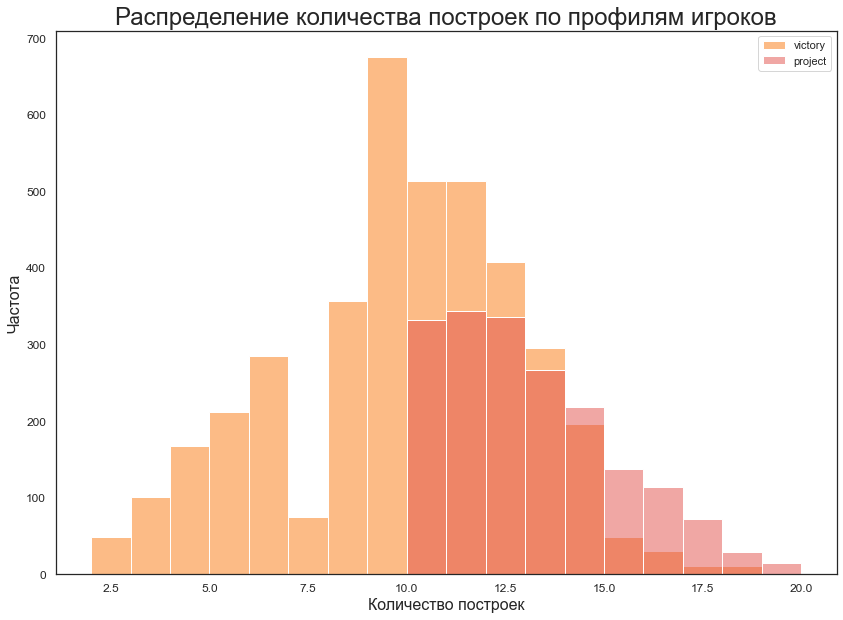

In [39]:
sns.histplot(build_cnt_victory['building_type'], label = 'victory', bins = 22, binwidth=1, 
             color = sns.color_palette('Spectral')[1])
sns.histplot(build_cnt_project['building_type'], label = 'project', alpha = 0.5, bins = 22, binwidth=1,
             color = sns.color_palette('Spectral')[0])

plt.xlabel('Количество построек')
plt.ylabel('Частота')
plt.title('Распределение количества построек по профилям игроков')
plt.legend()
plt.show();

In [40]:
build_cnt_project = pd.concat([build_cnt_project, build_cnt_project\
                            .sample((len(build_cnt_victory) - len(build_cnt_project)), replace = True)])
print(len(build_cnt_victory))
print(len(build_cnt_victory))

3951
3951


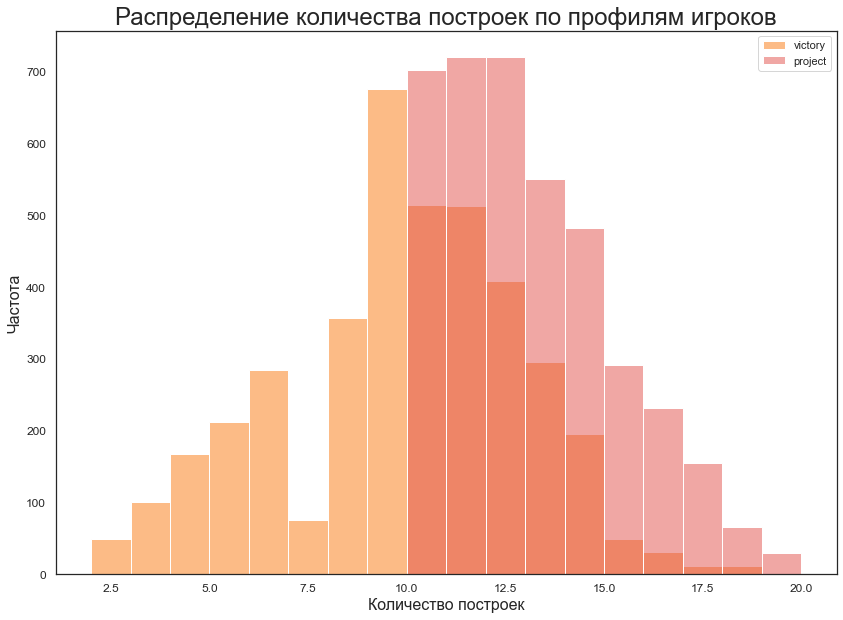

In [41]:
sns.histplot(build_cnt_victory['building_type'], label = 'victory', bins = 22, binwidth=1, 
             color = sns.color_palette('Spectral')[1])
sns.histplot(build_cnt_project['building_type'], label = 'project', alpha = 0.5, bins = 22, binwidth=1,
             color = sns.color_palette('Spectral')[0])

plt.xlabel('Количество построек')
plt.ylabel('Частота')
plt.title('Распределение количества построек по профилям игроков')
plt.legend()
plt.show();

Проверка на нормальность

In [42]:
results = st.shapiro(build_cnt_project['building_type'])
print('p-значение project:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, распределение нормально")   
    
print()

results = st.shapiro(build_cnt_victory['building_type'])
print('p-значение victory:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, распределение нормально")   
    

p-значение project: 1.5953783016338042e-41
Отвергаем нулевую гипотезу, распределение не нормально

p-значение victory: 1.8509618116696005e-26
Отвергаем нулевую гипотезу, распределение не нормально


Снова можно применить U-критерий Манна-Уитни

In [43]:
results = st.mannwhitneyu(build_cnt_project['building_type'], build_cnt_victory['building_type'], alternative = 'two-sided')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение: 0.0
Отвергаем нулевую гипотезу: разница статистически значима


Количество построек статистически различно для разных профилей игроков

# Вывод

Модели монетизации:
- При заданной модели монетизации (реклама на экране выбора постройки) прибыль с игроков была 8957 и показывалось 127957 реклам
- При новой модели монетизации (реклама в начале игровой сессии раз в день + 2 рекламы после завершения уровня, а также оптимизацию маркеинговых затрат) прибыль с игроков составила 7478.45 и показывалось 106835 реклам

Маркетинг:
- Больше всего пользователей приходят из `yandex` и `instagram`, затем идут `facebook` и `youtube`
- Самые низкие средние цены за клик в `youtube` и `yandex`, самый дорогой клик в `facebook`
- Реклама в `facebook` самая дорогая, пользователей приходит немного, плохо окупаются
- При исключении из данных `facebook` и `instagram` увеличивается ROI и уменьшается CAC по остальным источникам, поэтому есть смысл отказаться от них и перераспределить маркетинговый бюджет в пользу `youtube` и `yandex`

Метрики:
- Показатели удержания и ROI для обеих моделей монетизации самые высокие у `project`, затем `victory` и `not_finished`, причем у `project` показатели значительно выше, чем у остальных профилей
- Наибольший 'скачок' в значениях удержания произошел во 2 и 3 недели, т. е. именно к концу 3 недели большинство игроков закончили уровень, либо покинули игру
- Для всех пользователей (`game_actions`) при первоначальной модели монетизации LTV/CAC превысило оптимальное значение 3 к 3 неделе, а максимальное значение за все время почти 6, ROI при этом достиг уровня 17%
- Для новой модели соотношение LTV/CAC также превысило оптимальное к 3 неделе, максимум стал чуть больше 6, а ROI составил около 25%


Таким образом рекламная нагрузка и затраты на маркетинг снижены, а доход превышает расходы, поэтому можно принять 2 модель монетизации, при которой реклама показывается в начале каждой игровой сессии, но только раз в день, и еще 2 после завершения уровня


Для лучшего удержания, вовлечения в игру и лучшей окупаемости стоит:
- оптимизировать рекламные затраты (выбирать источником привлечения `yandex` или `youtube`)
- сподвигать игрока реализовать проект
- усложнить процесс борьбы с другим игроком, чтобы была потребность строить больше сооружений
- добавить ежедневные бонусы, чтобы игроки чаще возвращались